# 왕관스티커 붙이기 (실습)

## 1. 사진준비하기
1-1. 수염사진 :moustache.png

1-2. 셀프 image1.png


## 2. 이미지처리를 위한 라이브러리 불러오기

2-1. opencv-python cmake  dlib  이미지 처리 관련 패키지들 터미널에서 설치
2-2 이미지 처리를 위해 opencv 와 노트북에 이미지를 출력하기 위한 matplotlib 불러오기

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## 3. 이미지 읽기

3-1. 이미지 크기를 변경: 640x360의 VGA 크기(16:9)로 고정
3-2. 이미지가 푸른 빛이 감도는 것은 opencv의 특징. 
-  matplotlib, dlib 등의 이미지 라이브러리 : RGB순으로 사용
-  opencv는 BRG 를 사용해서 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력됨


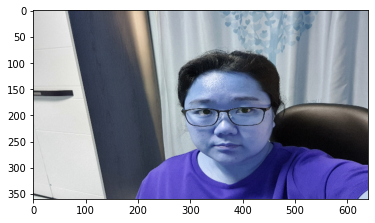

In [5]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image1.png'
img_bgr = cv2.imread(my_image_path, -1)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))   # 640x360의 크기로 Resize
img_show = img_bgr.copy()                   #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

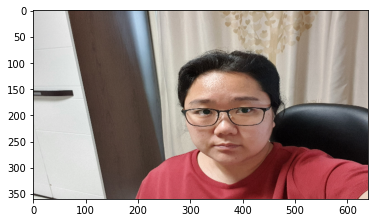

In [7]:
# opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하기위해 색깔 보정처리

# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 4. 얼굴 검출  face detection 

In [8]:
# 4-1. dlib을 활용해 hog detector를 선언
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

In [9]:
# 4-2. detector를 이용해서 얼굴의 bounding box를 추출
# dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 
# opencv 의 bgr 이미지를 rgb로 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

rectangles[[(287, 150) (442, 305)]]


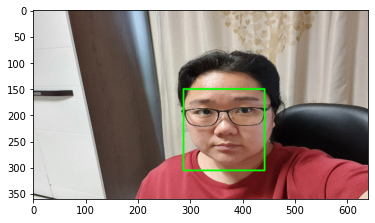

In [10]:
# 4-3 찾은 얼굴 화면에 출력 
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 5. 얼굴 랜드마크 face landmark

In [11]:
# 5-1.landmark 모델 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [12]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


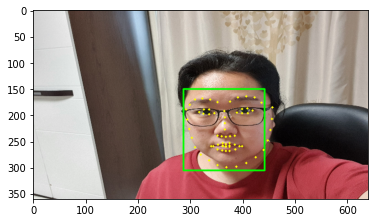

In [13]:
# 5-2. 랜드마크를 영상에 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 6. 스티커 적용하기

In [14]:
#6-1. 좌표 확인하기

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    
    # 코의 중심점은 366, 277

(366, 227)
(x,y) : (366,149)
(w,h) : (156,156)


In [15]:
# 6-2. 준비해둔 스티커 이미지 적용해보기
# 왕관 이미지를 읽고 윗 단계에서 계산한 크기로 resize 
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))  # 바운딩박스만큼 크기조정
print (img_sticker.shape)

(156, 156, 3)


In [16]:
# 6-3 .원본이미지에 스티커 이미지를 추가하기 위해서 x,y 좌표를 조정. 
# 이미지 시작점은 top-left 좌표이기때문
refined_x = x - w // 2  # left  코중심에서 폭의 1/2만큼 뺸값, 왼쪽위꼭지로이동
refined_y = y - h       # top 이미 이마점으로 이동된 y을 높이만큼 더 올림
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))
# - 7 이 나온 y축 좌표갑이 음수, 

(x,y) : (288,-7)


In [17]:
# 6-4 원본 이미지 범위를 벗어난 스티커 부분을 제거하기위한 코드
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)
# 마이너스 크기만큼 스티커를 crop 한다.

(149, 156, 3)


In [18]:
# top 의 y 좌표는 원본 이미지의 경계 값으로 수정
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (288,0)


In [19]:
# 6-5. 원본이미지에 스티커 적용
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

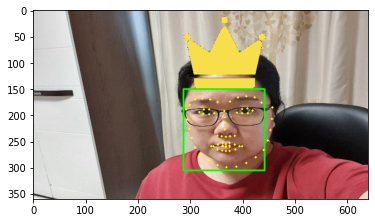

In [20]:
# 결과 이미지 적용
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

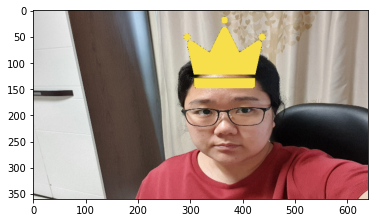

In [21]:
#bounding box와 landmark를 제거하고 최종 결과만 출력. 
# img_show 대신, 지금까지 아껴 두었던 img_rgb를 활용하여 보여주기

sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 수염스티커 만들고 적용하기(PROJECT)
1. 수염이미지 다운로드 함
2. 실습에 사용한 셀카파일 (이름변경)image3.png
3. 라이브러리 불러오기

In [73]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

4. 이미지 불러오기 

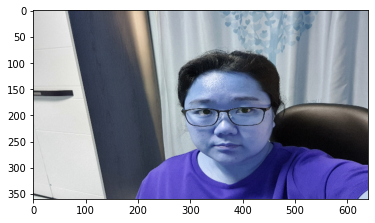

In [74]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image3.png'
img_bgr = cv2.imread(my_image_path, -1)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))   # 640x360의 크기로 Resize
img_show = img_bgr.copy()                   #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

5. 색 보정하기

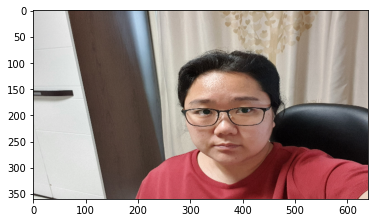

In [75]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [76]:
# 6. 얼굴 검출하기
import dlib
detector_hog = dlib.get_frontal_face_detector() 

In [77]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) 

rectangles[[(287, 150) (442, 305)]]


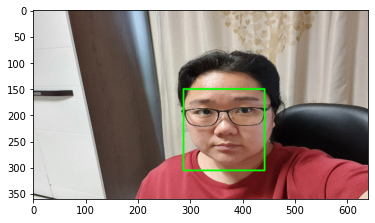

In [78]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [79]:
#7 .얼굴 landmark
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [82]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(list_landmarks[0])

[(292, 189), (294, 208), (298, 226), (303, 243), (309, 261), (320, 275), (336, 286), (352, 295), (369, 299), (388, 298), (407, 291), (425, 280), (440, 266), (448, 248), (453, 228), (456, 207), (457, 185), (299, 180), (309, 170), (323, 168), (338, 170), (352, 175), (376, 174), (391, 166), (407, 164), (423, 166), (436, 176), (365, 192), (366, 204), (366, 215), (366, 227), (352, 239), (360, 240), (368, 241), (376, 240), (385, 239), (317, 194), (326, 189), (336, 189), (346, 196), (336, 198), (325, 197), (389, 195), (399, 188), (409, 187), (419, 191), (410, 196), (399, 196), (340, 259), (353, 256), (362, 253), (368, 255), (375, 253), (385, 256), (399, 259), (386, 265), (375, 268), (368, 268), (361, 267), (352, 265), (344, 259), (362, 258), (368, 259), (375, 258), (394, 259), (375, 260), (368, 260), (362, 259)]


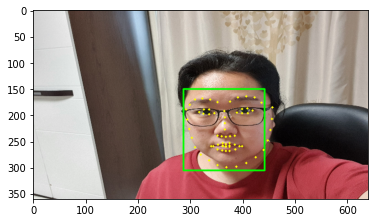

In [81]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [83]:
# 8 좌표확인

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) 
    x = landmark[30][0]  
    y = landmark[30][1]  
    w = (landmark[30][0] - landmark[36][0])*2
    h = (landmark[48][1] - landmark[2][1])*2
    print ('(x,y) : (%d,%d)'%(x,y))  
    print ('(w,h) : (%d,%d)'%(w,h))  
    
#중점을 코로 두고 W는 (30번.x - 36번.x) *2 H는 (2번.y - 48번.y) *2   

(366, 227)
(x,y) : (366,227)
(w,h) : (98,66)


In [84]:
# 9. 이미지 스티커 
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers1.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(66, 98, 3)


In [85]:
# 10 원본이미지에 스티머 이미지 추가 하기 위한 x. y 좌표조정

refined_x = x-w//2
refined_y = y-h//2
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (317,194)


In [86]:
# 원본이미지에 스티커 적용
x_shape = img_sticker.shape[0]
y_shape = img_sticker.shape[1]
print('(x_shape,y_shape) : (%d,%d)'%(x_shape, y_shape))

sticker_area = img_show[refined_y:refined_y+x_shape, refined_x:refined_x+y_shape]
img_show[refined_y:refined_y+x_shape, refined_x:refined_x+y_shape] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

(x_shape,y_shape) : (66,98)


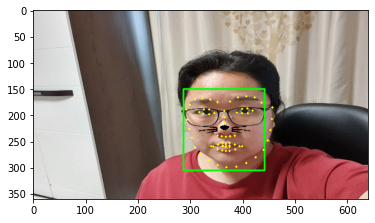

In [87]:
# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

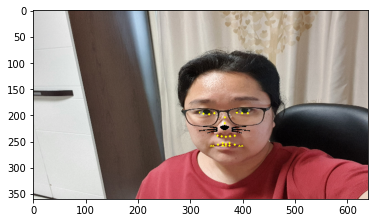

In [96]:
sticker_area = img_show[refined_y:refined_y+x_shape, refined_x:refined_x+y_shape]
img_bgr[refined_y:refined_y+x_shape, refined_x:refined_x+y_shape] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()